# Object Detection with DETR - a minimal implementation

In this notebook we show a demo of DETR (Detection Transformer), with slight differences with the baseline model in the paper.

We show how to define the model, load pretrained weights and visualize bounding box and class predictions.

Let's start with some common imports.

In [1]:
from PIL import Image
import requests
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'
from argparse import Namespace

import torch
torch.set_grad_enabled(False)

from detr.models import build_model
from detr.util.demo import rescale_bboxes, transform

## DETR
Here is a minimal implementation of DETR:

As you can see, DETR architecture is very simple, thanks to the representational power of the Transformer. There are two main components:
* a convolutional backbone - we use ResNet-50 in this demo
* a Transformer - we use the default PyTorch nn.Transformer


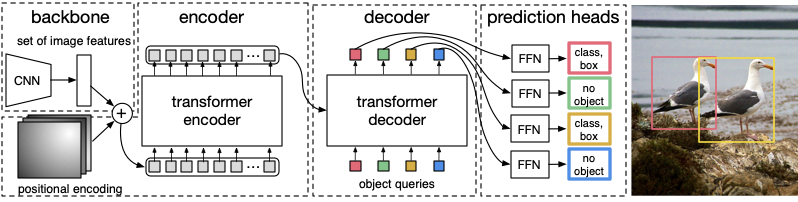

Let's construct the model with 80 COCO output classes + 1 ⦰ "no object" class and load the pretrained weights.
The weights are saved in half precision to save bandwidth without hurting model accuracy.

## Computing predictions with DETR

The pre-trained DETR model that we have just loaded has been trained on the 80 COCO classes, with class indices ranging from 1 to 90 (that's why we considered 91 classes in the model construction).
In the following cells, we define the mapping from class indices to names.

DETR uses standard ImageNet normalization, and output boxes in relative image coordinates in $[x_{\text{center}}, y_{\text{center}}, w, h]$ format, where $[x_{\text{center}}, y_{\text{center}}]$ is the predicted center of the bounding box, and $w, h$ its width and height. Because the coordinates are relative to the image dimension and lies between $[0, 1]$, we convert predictions to absolute image coordinates and $[x_0, y_0, x_1, y_1]$ format for visualization purposes.

Let's put everything together in a `detect` function, see other functions in the `util.demo` module.

## Using DETR
To try DETRdemo model on your own image just change the URL below.

In [2]:
args = Namespace(
    dataset_file = 'coco',
    device='cpu',
    hidden_dim=256,
    position_embedding='sine',
    lr_backbone=1e-5,
    masks=False,
    backbone='resnet50',
    dilation=True,
    dropout=0.1,
    nheads=8,
    dim_feedforward=2048,
    enc_layers=6,
    dec_layers=2,
    pre_norm=False,
    num_queries=100,
    aux_loss=False,
    set_cost_class=1,
    set_cost_bbox=5,
    set_cost_giou=2,
    bbox_loss_coef=5,
    giou_loss_coef=2,
    eos_coef=.1,
    eval=False,
)
model, _, _ = build_model(args)
state_dict = torch.hub.load_state_dict_from_url(url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth')['model']
model.load_state_dict(state_dict, strict=False);


In [3]:
def detect(im, model, transform):
    # mean-std normalize the input image (batch-size: 1)
    img = transform(im).unsqueeze(0)

    # demo model only support by default images with aspect ratio between 0.5 and 2
    # if you want to use images with an aspect ratio outside this range
    # rescale your image so that the maximum size is at most 1333 for best results
    assert img.shape[-2] <= 1600 and img.shape[-1] <= 1600, 'demo model only supports images up to 1600 pixels on each side'

    # propagate through the model
    outputs = model(img)

    # keep only predictions with 0.7+ confidence
    probas = outputs['pred_logits'].softmax(-1)[0, :, :-1]
    keep = probas.max(-1).values > 0.7

    # convert boxes from [0; 1] to image scales
    bboxes_scaled = rescale_bboxes(outputs['pred_boxes'][0, keep], im.size)
    return probas[keep], bboxes_scaled

In [4]:
url = 'http://images.cocodataset.org/val2017/000000039769.jpg'
im = Image.open(requests.get(url, stream=True).raw)

scores, boxes = detect(im, model, transform)

Let's now visualize the model predictions

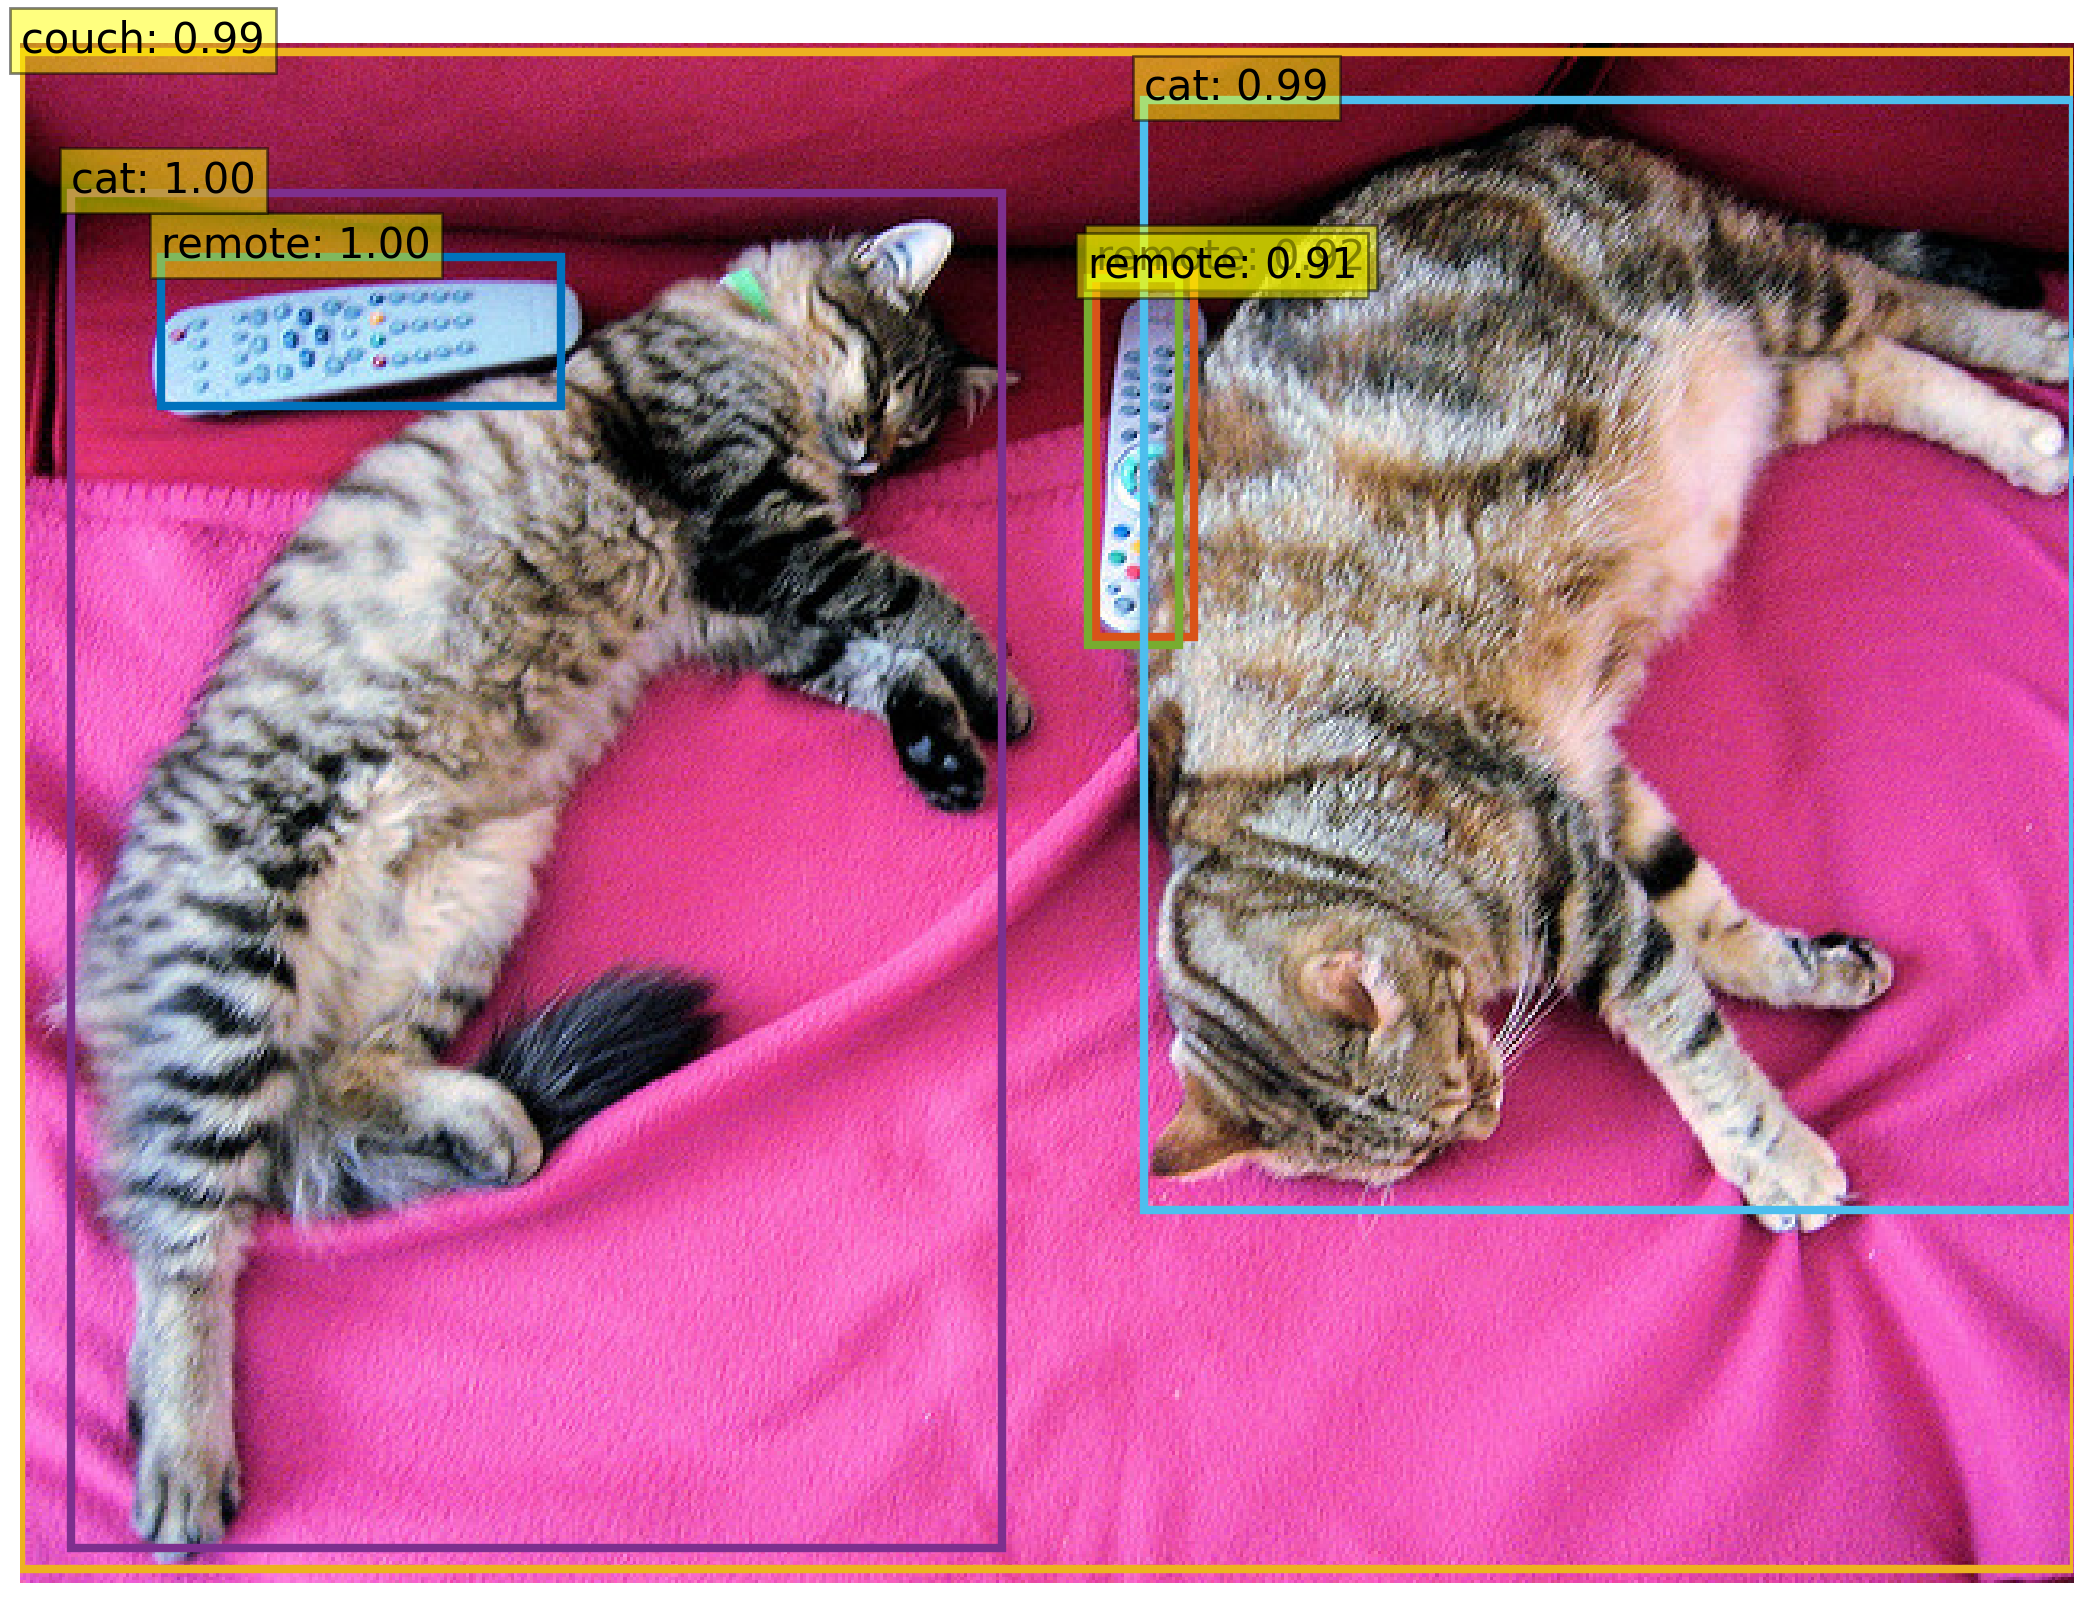

In [6]:
# COCO classes
CLASSES = [
    'N/A', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A',
    'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse',
    'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack',
    'umbrella', 'N/A', 'N/A', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis',
    'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove',
    'skateboard', 'surfboard', 'tennis racket', 'bottle', 'N/A', 'wine glass',
    'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich',
    'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake',
    'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table', 'N/A',
    'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard',
    'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A',
    'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier',
    'toothbrush'
]

# colors for visualization
COLORS = [[0.000, 0.447, 0.741], [0.850, 0.325, 0.098], [0.929, 0.694, 0.125],
          [0.494, 0.184, 0.556], [0.466, 0.674, 0.188], [0.301, 0.745, 0.933]]

def plot_results(pil_img, prob, boxes):
    plt.figure(figsize=(16,10))
    plt.imshow(pil_img)
    ax = plt.gca()
    for p, (xmin, ymin, xmax, ymax), c in zip(prob, boxes.tolist(), COLORS * 100):
        ax.add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                   fill=False, color=c, linewidth=3))
        cl = p.argmax()
        text = f'{CLASSES[cl]}: {p[cl]:0.2f}'
        ax.text(xmin, ymin, text, fontsize=15,
                bbox=dict(facecolor='yellow', alpha=0.5))
    plt.axis('off')
    plt.show()

plot_results(im, scores, boxes)